In [1]:
from pathlib import Path

import earthkit.data
import earthkit.plots
import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_wasm_sz3 import Sz3
from numcodecs_wasm_tthresh import Tthresh

In [2]:
t2m = xr.open_dataset(
    Path() / ".." / "bench" / "era5_t2m_2012_12_01_14:00.nc",
    engine="netcdf4",
).t2m

# convert from K to degC
with xr.set_options(keep_attrs=True):
    t2m = t2m - 273.15
t2m.attrs["units"] = t2m.attrs["GRIB_units"] = "degC"

t2m

<xarray.DataArray 't2m' (valid_time: 1, latitude: 721, longitude: 1440)> Size: 4MB
array([[[-12.350586, -12.350586, -12.350586, ..., -12.350586,
         -12.350586, -12.350586],
        [-12.532227, -12.530273, -12.52832 , ..., -12.540039,
         -12.538086, -12.53418 ],
        [-12.850586, -12.844727, -12.838867, ..., -12.868164,
         -12.864258, -12.858398],
        ...,
        [-26.989258, -26.987305, -26.987305, ..., -26.993164,
         -26.99121 , -26.99121 ],
        [-27.188477, -27.188477, -27.186523, ..., -27.19043 ,
         -27.19043 , -27.188477],
        [-27.637695, -27.637695, -27.637695, ..., -27.637695,
         -27.637695, -27.637695]]], shape=(1, 721, 1440), dtype=float32)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8B 2012-12-01T14:00:00
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      <U4 16B ...
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               degC
    long_name:                                2 metre temperature
    units:                                    degC
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [3]:
vmin, vmax = int(np.floor(np.amin(t2m))), int(np.ceil(np.amax(t2m)))
vlim = max(abs(vmin), abs(vmax))
vmin, vmax, vlim

(-50, 39, 50)

In [4]:
sz3_abs = Sz3(eb_mode="abs", eb_abs=0.1)

encoded_sz3_abs = sz3_abs.encode(t2m.values)
decoded_sz3_abs = t2m.copy(deep=True, data=sz3_abs.decode(encoded_sz3_abs))

In [5]:
sz3_abs_sg = SafeguardsCodec(codec=sz3_abs, safeguards=[dict(kind="abs", eb_abs=0.1)])

encoded_sz3_abs_sg = sz3_abs_sg.encode(t2m.values)
decoded_sz3_abs_sg = t2m.copy(
    deep=True, data=sz3_abs_sg.decode(encoded_sz3_abs_sg, out=np.empty_like(t2m.values))
)

In [6]:
sz3_rel = Sz3(eb_mode="rel", eb_rel=0.1)

encoded_sz3_rel = sz3_rel.encode(t2m.values)
decoded_sz3_rel = t2m.copy(deep=True, data=sz3_rel.decode(encoded_sz3_rel))

In [7]:
sz3_rel_sg = SafeguardsCodec(codec=sz3_rel, safeguards=[dict(kind="rel", eb_rel=0.1)])

encoded_sz3_rel_sg = sz3_rel_sg.encode(t2m.values)
decoded_sz3_rel_sg = t2m.copy(
    deep=True, data=sz3_rel_sg.decode(encoded_sz3_rel_sg, out=np.empty_like(t2m.values))
)

In [8]:
tthresh_abs = Tthresh(eb_mode="rmse", eb_rmse=0.1)

encoded_tthresh_abs = tthresh_abs.encode(t2m.values)
decoded_tthresh_abs = t2m.copy(deep=True, data=tthresh_abs.decode(encoded_tthresh_abs))

oldbits = 33223680, newbits = 112336, compressionratio = 295.753, bpv = 0.108198


In [9]:
tthresh_abs_sg = SafeguardsCodec(
    codec=tthresh_abs, safeguards=[dict(kind="abs", eb_abs=0.1)]
)

encoded_tthresh_abs_sg = tthresh_abs_sg.encode(t2m.values)
decoded_tthresh_abs_sg = t2m.copy(
    deep=True,
    data=tthresh_abs_sg.decode(encoded_tthresh_abs_sg, out=np.empty_like(t2m.values)),
)

oldbits = 33223680, newbits = 112336, compressionratio = 295.753, bpv = 0.108198


In [10]:
tthresh_rel = Tthresh(eb_mode="eps", eb_eps=0.1)

encoded_tthresh_rel = tthresh_rel.encode(t2m.values)
decoded_tthresh_rel = t2m.copy(deep=True, data=tthresh_rel.decode(encoded_tthresh_rel))

oldbits = 33223680, newbits = 10768, compressionratio = 3085.41, bpv = 0.0103714


In [11]:
tthresh_rel_sg = SafeguardsCodec(
    codec=tthresh_rel, safeguards=[dict(kind="rel", eb_rel=0.1)]
)

encoded_tthresh_rel_sg = tthresh_rel_sg.encode(t2m.values)
decoded_tthresh_rel_sg = t2m.copy(
    deep=True,
    data=tthresh_rel_sg.decode(encoded_tthresh_rel_sg, out=np.empty_like(t2m.values)),
)

oldbits = 33223680, newbits = 10768, compressionratio = 3085.41, bpv = 0.0103714


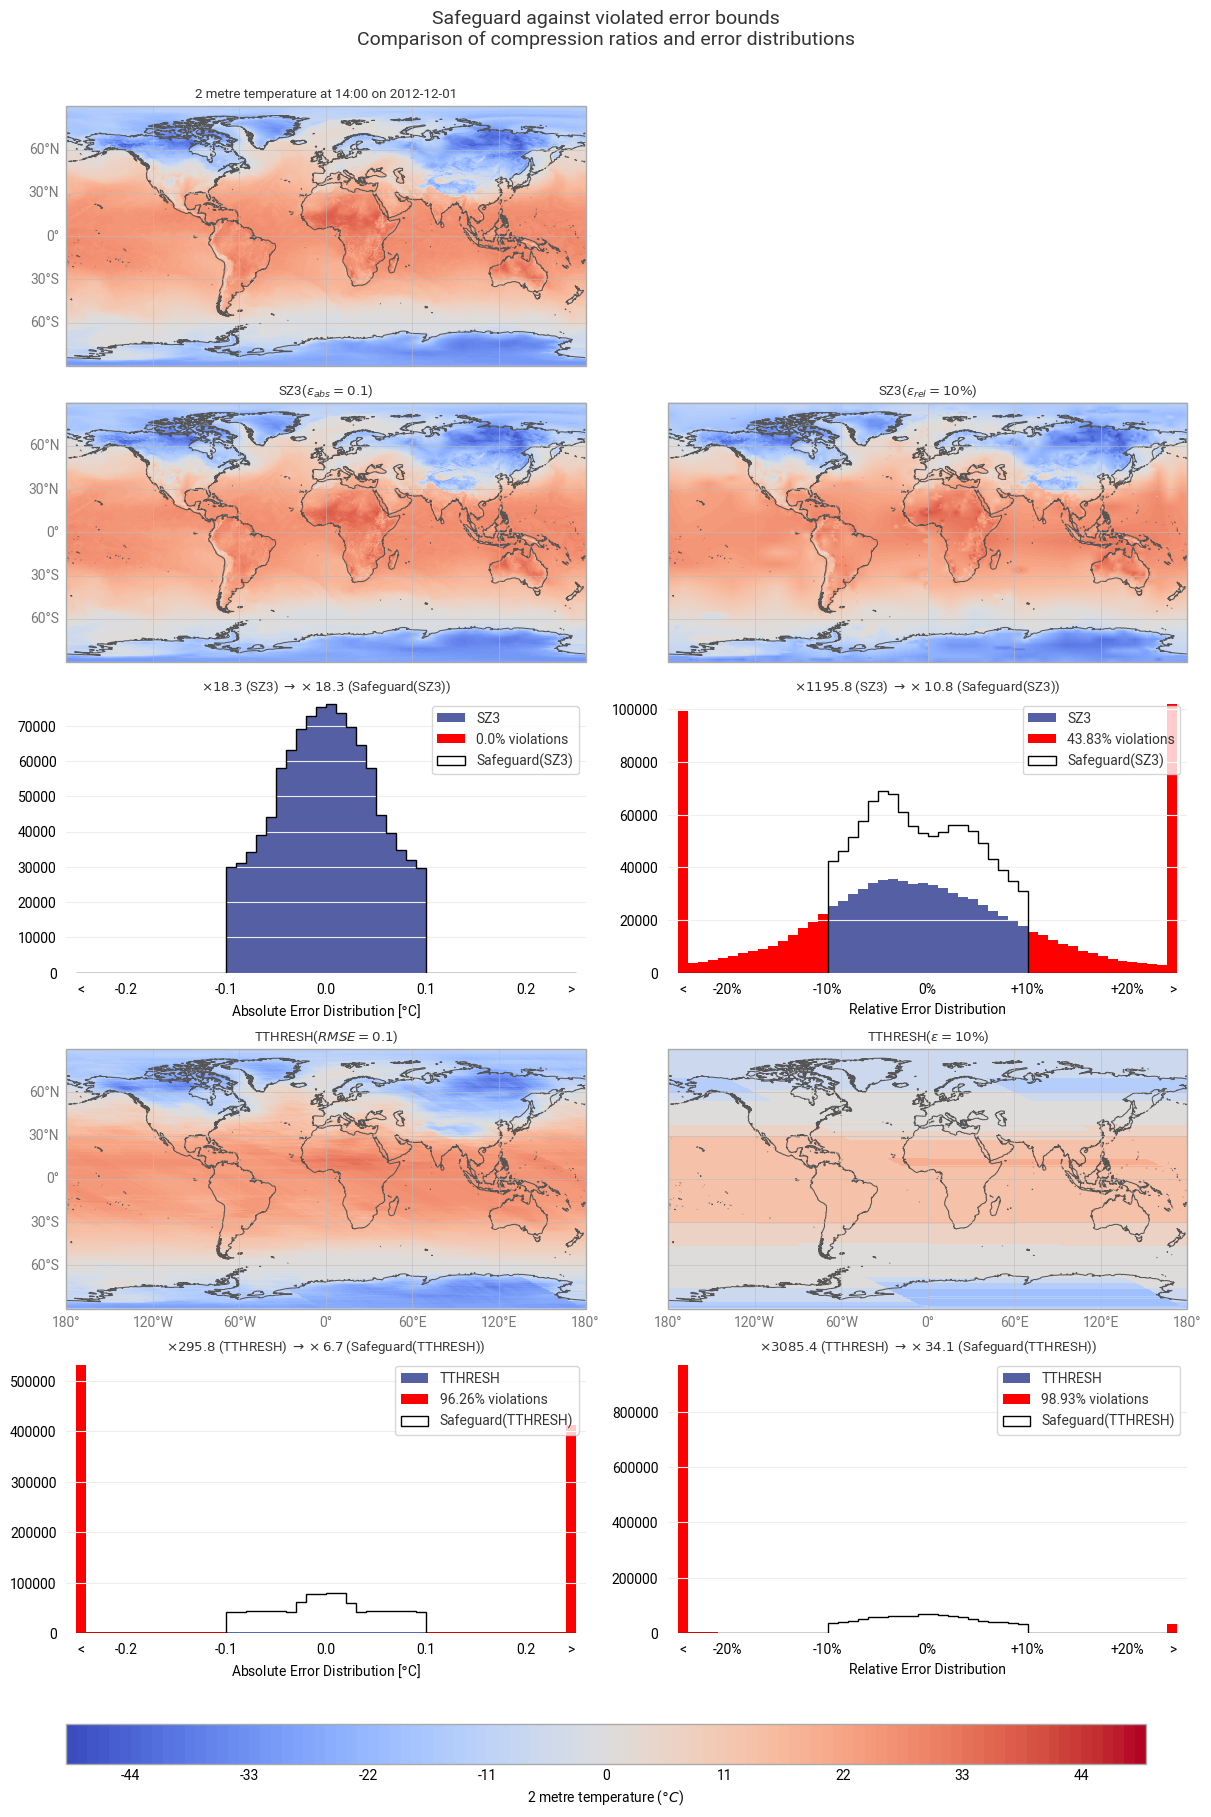

In [12]:
figure = earthkit.plots.Figure(
    size=(12, 16),
    rows=5,
    columns=2,
)


def quicksubmap(i, j, data, *args, **kwargs):
    subplot = figure.add_map(i, j)
    subplot.pcolormesh(
        earthkit.data.from_object(data),
        style=earthkit.plots.Style(
            levels=np.linspace(-vlim, vlim, vlim * 2 + 1),
            colors="coolwarm",
        ),
        rasterized=True,
    )
    for m in earthkit.plots.schema.quickmap_subplot_workflow:
        getattr(subplot, m)()
    return subplot


def quicksubhist(i, j, data, data_sg, name, is_rel):
    if is_rel:
        err = (data - t2m) / t2m
        err_sg = (data_sg - t2m) / t2m
    else:
        err = data - t2m
        err_sg = data_sg - t2m
    err = err.values.flatten()
    err_sg = err_sg.values.flatten()

    subplot = figure.add_subplot(i, j)
    subplot.ax.hist(
        err[np.abs(err) <= 0.1],
        range=(-0.25, 0.25),
        bins=50,
        label=name,
    )
    subplot.ax.hist(
        np.clip(err[np.abs(err) > 0.1], -0.25, 0.25),
        range=(-0.25, 0.25),
        bins=50,
        color="red",
        label=f"{np.round(np.mean(np.abs(err) > 0.1) * 100, 2)}% violations",
    )
    subplot.ax.hist(
        err_sg,
        range=(-0.25, 0.25),
        bins=50,
        histtype="step",
        color="black",
        label=f"Safeguard({name})",
    )
    subplot.ax.set_xticks(
        [-0.245, -0.2, -0.1, 0.0, 0.1, 0.2, 0.245],
        (
            ["<", "-20%", "-10%", "0%", "+10%", "+20%", ">"]
            if is_rel
            else ["<", "-0.2", "-0.1", "0.0", "0.1", "0.2", ">"]
        ),
    )
    subplot.ax.legend(loc="upper right")
    subplot.ax.set_xlabel(
        "Relative Error Distribution"
        if is_rel
        else r"Absolute Error Distribution [$\degree$C]"
    )
    return subplot


quicksubmap(0, 0, t2m)
quicksubmap(1, 0, decoded_sz3_abs).title(r"SZ3($\epsilon_{{abs}}=0.1$)")
quicksubmap(1, 1, decoded_sz3_rel).title(r"SZ3($\epsilon_{{rel}}=10\%$)")
quicksubmap(3, 0, decoded_tthresh_abs).title(r"TTHRESH($RMSE=0.1$)")
quicksubmap(3, 1, decoded_tthresh_rel).title(r"TTHRESH($\epsilon=10\%$)")

for m in earthkit.plots.schema.quickmap_figure_workflow:
    if m != "legend":
        getattr(figure, m)()

quicksubhist(2, 0, decoded_sz3_abs, decoded_sz3_abs_sg, "SZ3", False).title(
    rf"$\times {round(t2m.nbytes / encoded_sz3_abs.nbytes, 1)}$ (SZ3) $\rightarrow "
    rf"\times {round(t2m.nbytes / len(encoded_sz3_abs_sg), 1)}$ (Safeguard(SZ3))"
)
quicksubhist(2, 1, decoded_sz3_rel, decoded_sz3_rel_sg, "SZ3", True).title(
    rf"$\times {round(t2m.nbytes / encoded_sz3_rel.nbytes, 1)}$ (SZ3) $\rightarrow "
    rf"\times {round(t2m.nbytes / len(encoded_sz3_rel_sg), 1)}$ (Safeguard(SZ3))"
)
quicksubhist(4, 0, decoded_tthresh_abs, decoded_tthresh_abs_sg, "TTHRESH", False).title(
    rf"$\times {round(t2m.nbytes / encoded_tthresh_abs.nbytes, 1)}$ (TTHRESH) $\rightarrow "
    rf"\times {round(t2m.nbytes / len(encoded_tthresh_abs_sg), 1)}$ (Safeguard(TTHRESH))"
)
quicksubhist(4, 1, decoded_tthresh_rel, decoded_tthresh_rel_sg, "TTHRESH", True).title(
    rf"$\times {round(t2m.nbytes / encoded_tthresh_rel.nbytes, 1)}$ (TTHRESH) $\rightarrow "
    rf"\times {round(t2m.nbytes / len(encoded_tthresh_rel_sg), 1)}$ (Safeguard(TTHRESH))"
)

ax = plt.axes((0.05, -0.05, 0.9, 0.025))
figure.legend(ax=ax)

figure.title(
    "Safeguard against violated error bounds\nComparison of compression ratios and error distributions"
)

figure.save("soft.pdf")
figure.show()